In [70]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import datetime
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

import os
import warnings
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
model_path = './transformer_model/'
os.makedirs(model_path, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
torch.cuda.is_available()

True

In [52]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)

In [53]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
train_columns = train_data.columns.drop(target_column)
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].dropna().values
del train_data, test_data

In [54]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days
data.policy_start_date.isna().sum()

0

In [55]:
class TorchStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.fitted = False

    def fit(self, data: torch.Tensor):
        """
        데이터의 평균(mean)과 표준 편차(std)를 계산하여 저장.

        Args:
            data (torch.Tensor): 학습할 데이터 텐서.
        """
        if not isinstance(data, torch.Tensor):
            raise ValueError("Input data must be a PyTorch tensor.")
        
        self.mean_ = data.mean(dim=0, keepdim=True)
        self.std_ = data.std(dim=0, unbiased=False, keepdim=True)
        self.fitted = True

    def transform(self, data: torch.Tensor) -> torch.Tensor:
        """
        데이터를 표준화 (mean=0, std=1)합니다.

        Args:
            data (torch.Tensor): 표준화할 데이터 텐서.
        
        Returns:
            torch.Tensor: 표준화된 데이터.
        """
        if not self.fitted:
            raise ValueError("Scaler has not been fitted yet.")
        return (data - self.mean_) / (self.std_ + 1e-8)  # 안정성을 위해 작은 값 추가

    def inverse_transform(self, data: torch.Tensor) -> torch.Tensor:
        """
        표준화된 데이터를 원래 스케일로 복원합니다.

        Args:
            data (torch.Tensor): 복원할 데이터 텐서.
        
        Returns:
            torch.Tensor: 원래 스케일로 변환된 데이터.
        """
        if not self.fitted:
            raise ValueError("Scaler has not been fitted yet.")
        return data * self.std_ + self.mean_

    def fit_transform(self, data: torch.Tensor) -> torch.Tensor:
        """
        데이터를 학습(fit)하고, 표준화(transform)한 결과를 반환합니다.

        Args:
            data (torch.Tensor): 학습하고 표준화할 데이터 텐서.
        
        Returns:
            torch.Tensor: 표준화된 데이터.
        """
        self.fit(data)
        return self.transform(data)

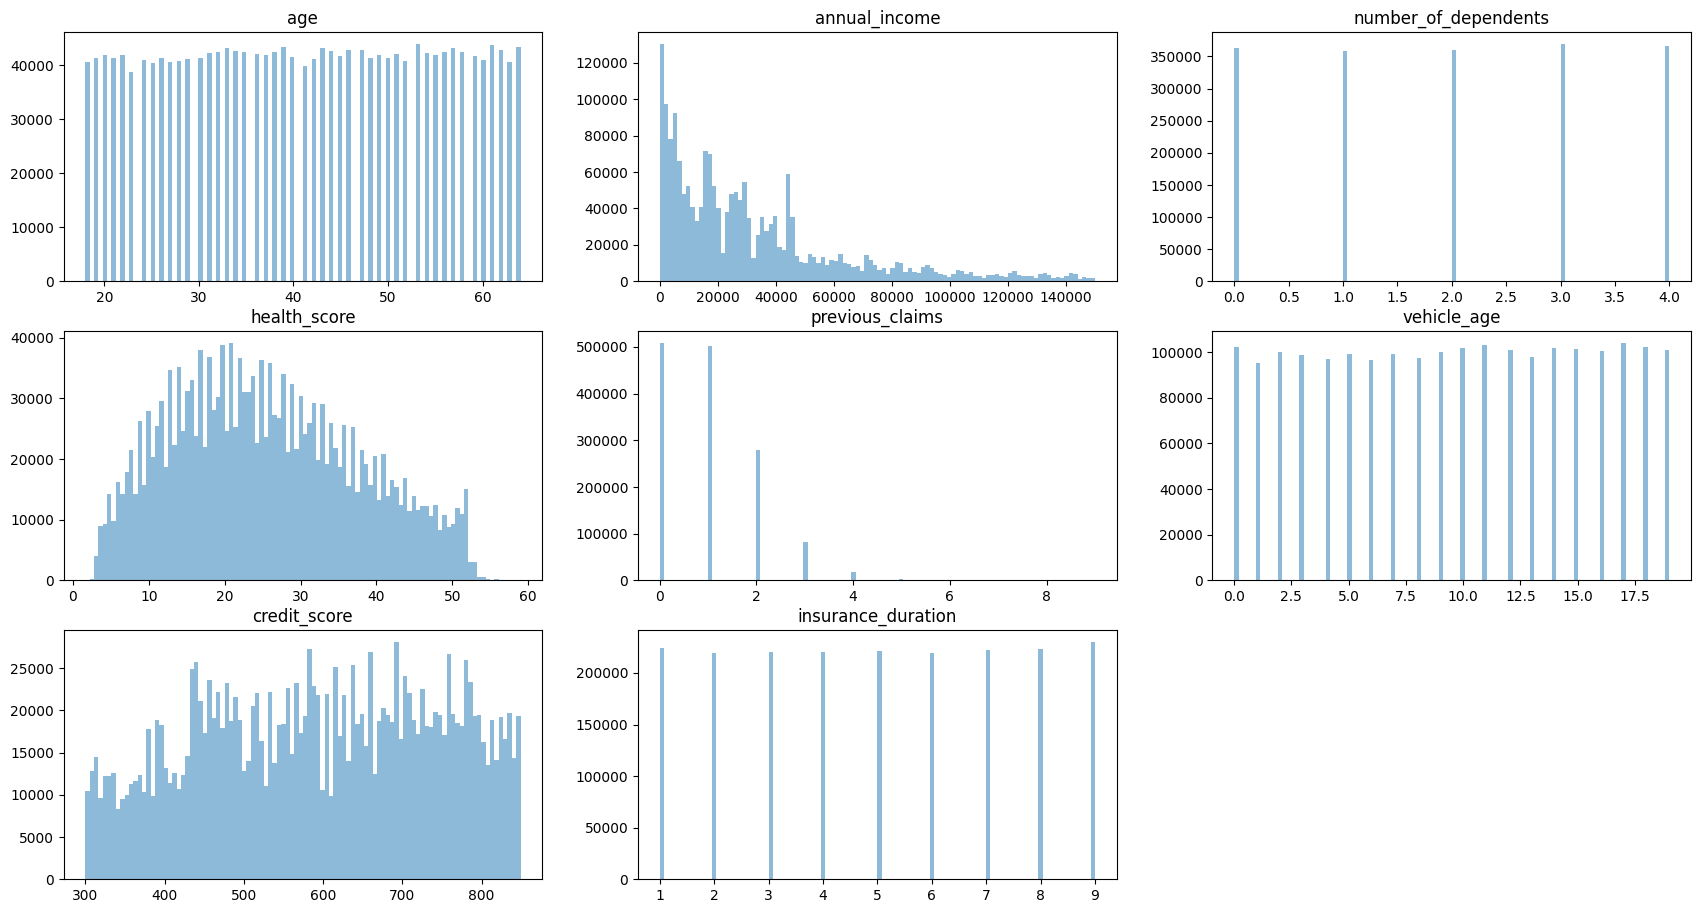

In [56]:
# plot the distribution of the target variable
float_columns = data.select_dtypes(include=['float64']).columns
plt.figure(figsize=(21, 11))
plt.subplot(3, 3, 1)
for col in float_columns:
    plt.subplot(3, 3, float_columns.get_loc(col)+1)
    plt.hist(data[col], bins=100, alpha=0.5, label=col)
    plt.title(col)


In [57]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=8, duplicates='raise')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=8, duplicates='raise')


categorical_columns = data.select_dtypes(include=['object', 'category']).columns
ordinal_categories = ['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims']
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])

# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
y_scaler_torch = TorchStandardScaler()
y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)
X = data[:len(y)].drop(columns=target_column).copy()

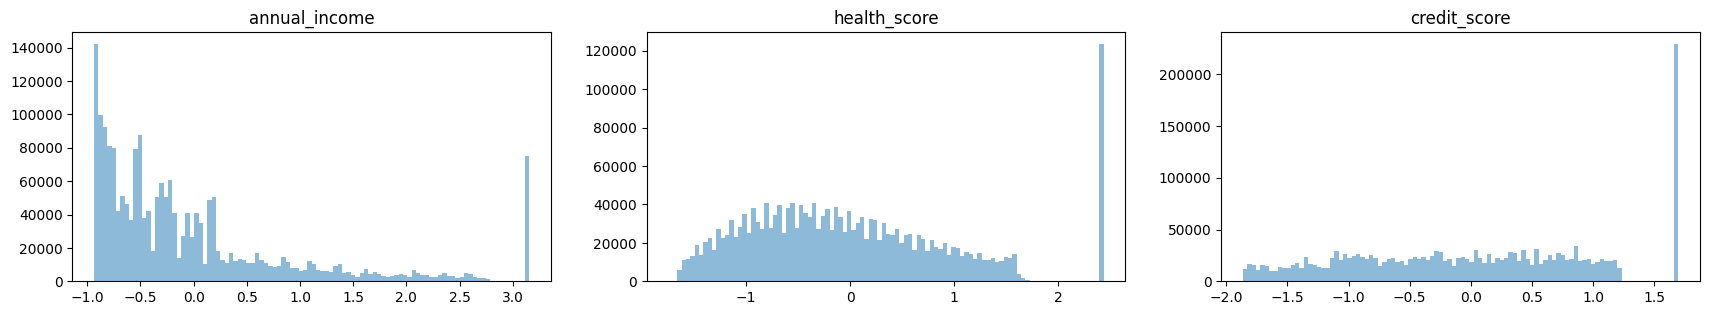

In [58]:
# plot the distribution of the target variable
plt.figure(figsize=(21, 11))
plt.subplot(3, 3, 1)
for col in float_columns:
    plt.subplot(3, 3, float_columns.get_loc(col)+1)
    plt.hist(data[col], bins=100, alpha=0.5, label=col)
    plt.title(col)


In [60]:
def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

def inverse_y_torch(y):
    return torch.expm1(y_scaler_torch.inverse_transform(y)).squeeze(-1)

def rmlse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)
    
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

In [61]:
data

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
id,,,,,,,,,,,,,,,,,,,,
0,0.0,0,-0.685909,1,1.0,0,1,-0.359399,2,2,2.0,6.0,-1.459636,4.0,1.300820,2,0,3,2,1.248538
1,3.0,0,-0.149665,0,3.0,2,3,-0.823814,0,1,1.0,4.0,0.347957,1.0,0.928832,0,1,1,2,0.646643
2,0.0,1,-0.300306,0,3.0,1,1,1.264546,1,2,1.0,5.0,1.694669,2.0,1.139753,1,1,3,2,-0.229752
3,0.0,1,2.581937,1,2.0,0,3,-1.129828,0,0,1.0,0.0,-1.487704,0.0,1.630624,2,1,0,0,0.043158
4,0.0,1,0.048009,2,1.0,0,1,-0.506253,0,2,0.0,3.0,-0.190953,3.0,-0.141113,2,1,3,2,0.929390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,5.0,0,0.026464,1,1.0,0,3,-0.894582,0,2,10.0,3.0,-1.813296,1.0,-0.419145,0,1,0,1,NaN
1999996,-1.0,0,0.886280,2,0.0,2,3,-1.314324,0,0,2.0,0.0,1.694669,1.0,0.783105,1,0,0,0,NaN
1999997,1.0,0,-0.062890,2,0.0,2,0,-1.414036,2,1,10.0,3.0,1.694669,5.0,-1.661661,2,0,1,0,NaN


In [62]:
# --- LGBoost 모델 결과 Feature 로 넣어주기 ---
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
FOLDS=5
SPLIT = True

# lgb cleanout
for col in data.columns:
    if 'lgb' in col:
        del data[col]
kf = KFold(n_splits=FOLDS, 
           shuffle=False,
)
_X = X.copy()
test_idx = data[target_column].isnull()
lgb_fold_predictions = []
"""
PREVIOUS PARAMS
num_leaves=31,
min_child_samples=20,
min_child_weight=0.001,

n_estimators=500,
max_depth=20,
learning_rate=0.1,
"""
for train_idx, val_idx in kf.split(_X):
    lgb_predictions = np.zeros(len(data))  # 예측값 저장
    X_train, X_val = _X.iloc[train_idx], _X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    lgbr = LGBMRegressor(
        **{   'num_leaves': 40,
            'min_child_samples': 10,
            'min_child_weight': 0.06465924287223622,
            'n_estimators': 459,
            'max_depth': 30,
            'learning_rate': 0.046995524079346984,
            'feature_fraction': 0.9677961468326596,
            'bagging_fraction': 0.6627290192138932,
            'lambda_l1': 8.692580281983838,
            'lambda_l2': 3.4256066884728638,
            'reg_alpha': 0.08455745202708774,
            'reg_lambda': 0.007744807329888691,
            'boosting_type': 'gbdt'
        },
        n_jobs=-1,
        random_state=42,
        # verbosity=1,
        force_row_wise=True,
        device="gpu",              # GPU 활성화
        gpu_use_dp=True            # 32-bit 정밀도 사용
    )
    lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=rmlse,) # use custom rmlse loss function
    print(evaluate_model(lgbr, X_val, y_val))
    if not SPLIT:
        lgb_predictions[val_idx] = lgbr.predict(X_val)
        lgb_predictions[test_idx] = lgbr.predict(data.loc[test_idx][train_columns])
    else:
        lgb_predictions[~np.isin(np.arange(0, len(data)), train_idx)] = lgbr.predict(data[train_columns].loc[~data.index.isin(train_idx)])
    
    lgb_fold_predictions.append(lgb_predictions)
if not SPLIT:
    lgb_predictions = np.sum(lgb_fold_predictions, axis=0)
    lgb_predictions[:len(y)] = lgb_predictions[:len(y)] / (FOLDS-1)
    lgb_predictions[len(y):] = lgb_predictions[len(y):] / FOLDS
    data['lgb_pred'] = lgb_predictions
else:
    lgb_predictions = np.vstack(lgb_fold_predictions).T
    data[[f'lgb_pred_{i}' for i in range(lgb_predictions.shape[1])]] = lgb_predictions
X = data[:len(y)].drop(columns=target_column).copy()
del _X, lgb_predictions, lgb_fold_predictions, lgbr

[LightGBM] [Warning] feature_fraction is set=0.9677961468326596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9677961468326596
[LightGBM] [Warning] lambda_l1 is set=8.692580281983838, reg_alpha=0.08455745202708774 will be ignored. Current value: lambda_l1=8.692580281983838
[LightGBM] [Warning] lambda_l2 is set=3.4256066884728638, reg_lambda=0.007744807329888691 will be ignored. Current value: lambda_l2=3.4256066884728638
[LightGBM] [Warning] bagging_fraction is set=0.6627290192138932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6627290192138932
[LightGBM] [Warning] feature_fraction is set=0.9677961468326596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9677961468326596
[LightGBM] [Warning] lambda_l1 is set=8.692580281983838, reg_alpha=0.08455745202708774 will be ignored. Current value: lambda_l1=8.692580281983838
[LightGBM] [Warning] lambda_l2 is set=3.4256066884728638, reg_lambda=0.007744807329888691 will be ig

In [260]:
# Without LGB
# lgb cleanout
for col in data.columns:
    if 'lgb' in col:
        del data[col]
kf = KFold(n_splits=FOLDS, 
           shuffle=False,
)
X = data[:len(y)].drop(columns=target_column).copy()

In [63]:
X.loc[:, X.columns.str.contains('lgb')]

,lgb_pred_0,lgb_pred_1,lgb_pred_2,lgb_pred_3,lgb_pred_4
id,,,,,
0,0.266684,0.0,0.0,0.0,0.000000
1,-0.021943,0.0,0.0,0.0,0.000000
2,0.109670,0.0,0.0,0.0,0.000000
3,0.035004,0.0,0.0,0.0,0.000000
4,0.075702,0.0,0.0,0.0,0.000000
...,...,...,...,...,...
1199995,0.000000,0.0,0.0,0.0,0.267237
1199996,0.000000,0.0,0.0,0.0,0.063346
1199997,0.000000,0.0,0.0,0.0,-1.277825


In [64]:

# --- 4. 데이터셋 및 DataLoader 정의 ---
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)
test_dataset = torch.tensor(data[data[target_column].isnull()].drop(columns=[target_column]).values, dtype=torch.float32)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [65]:
# --- Target Loss 정의 ---
class RMLSELoss(nn.Module):
    def __init__(self):
        super(RMLSELoss, self).__init__()
    
    def forward(self, preds, targets):
        # Inverse transform
        targets = inverse_y_torch(targets)
        preds = inverse_y_torch(preds)

        # Log transformation
        targets = torch.log1p(targets)
        preds = torch.log1p(preds)

        # RMLSE 계산
        loss = torch.sqrt(torch.mean((preds - targets) ** 2))
        return loss
    
# --- Target Loss 정의 ---
class MLSELoss(nn.Module):
    def __init__(self):
        super(MLSELoss, self).__init__()
    
    def forward(self, preds, targets):
        # Inverse transform
        targets = inverse_y_torch(targets)
        preds = inverse_y_torch(preds)

        # Log transformation
        targets = torch.log1p(targets)
        preds = torch.log1p(preds)

        # RMLSE 계산
        loss = torch.mean((preds - targets) ** 2)
        return loss


In [66]:
# --- 5. 트랜스포머 모델 정의 ---
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, hidden_dim, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.dropout_layer = nn.Dropout(dropout)  # Dropout 추가
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm = nn.LayerNorm(embed_dim)  # Layer Normalization 추가
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        # 입력 임베딩 및 드롭아웃 적용
        x = self.embedding(x)
        x = self.dropout_layer(x)

        # Transformer 인코더와 Layer Normalization 적용
        x = self.transformer_encoder(x)
        x = self.layer_norm(x)  # Normalization 추가

        # 출력 레이어
        x = self.fc(x)
        return x

# 모델 초기화
input_dim = X.shape[1]
model = TransformerModel(input_dim=input_dim, embed_dim=64, num_heads=4, num_layers=2, hidden_dim=128, output_dim=1)
model = TransformerModel(input_dim=input_dim, embed_dim=16, num_heads=1, num_layers=2, hidden_dim=32, output_dim=1)

In [71]:
# --- 6. 모델 학습 ---
model.to(device)

criterion = RMLSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
def train_model(model: torch.nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    val_loader: torch.utils.data.DataLoader, 
    criterion: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, 
    epochs=10
):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # 검증 루프
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        torch.save(model.state_dict(), model_path+f"model_{epoch:04d}_embed_dim={model.embed_dim}_num_heads={model.num_heads}_num_layers={model.num_layers}_hidden_dim={model.hidden_dim}_dropout={model.dropout}.pt")
        print(f"{datetime.datetime.now()}: Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

In [ ]:
# model.load_state_dict(torch.load(model_path+))

In [69]:
# target val loss is under 0.9124044109944525
# with dropout, layer normalization, lgb feature splited into folds
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 1.0429, Val Loss: 1.0399
Epoch 2/10, Train Loss: 1.0391, Val Loss: 1.0393
Epoch 3/10, Train Loss: 1.0385, Val Loss: 1.0396
Epoch 4/10, Train Loss: 1.0382, Val Loss: 1.0385
Epoch 5/10, Train Loss: 1.0380, Val Loss: 1.0386
Epoch 6/10, Train Loss: 1.0381, Val Loss: 1.0381
Epoch 7/10, Train Loss: 1.0379, Val Loss: 1.0384
Epoch 8/10, Train Loss: 1.0380, Val Loss: 1.0384
Epoch 9/10, Train Loss: 1.0376, Val Loss: 1.0382
Epoch 10/10, Train Loss: 1.0377, Val Loss: 1.0382


In [93]:
# target val loss is under 0.9124044109944525
# criterion is mse
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Train Loss: 0.9210, Val Loss: 0.9170
Epoch 2/10, Train Loss: 0.9148, Val Loss: 0.9145
Epoch 3/10, Train Loss: 0.9137, Val Loss: 0.9146
Epoch 4/10, Train Loss: 0.9133, Val Loss: 0.9140
Epoch 5/10, Train Loss: 0.9129, Val Loss: 0.9135
Epoch 6/10, Train Loss: 0.9127, Val Loss: 0.9134
Epoch 7/10, Train Loss: 0.9125, Val Loss: 0.9140
Epoch 8/10, Train Loss: 0.9124, Val Loss: 0.9137
Epoch 9/10, Train Loss: 0.9122, Val Loss: 0.9135
Epoch 10/10, Train Loss: 0.9121, Val Loss: 0.9135


In [72]:
model.eval()
predict = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).detach().cpu().numpy()
        predict.append(outputs)
        
outputs = np.concatenate(predict).reshape(-1)

In [73]:
from sklearn.metrics import root_mean_squared_log_error
y_pred = inverse_y(outputs)

In [74]:
y_pred

array([835.57745, 837.96954, 773.4485 , ..., 872.8475 , 813.08246,
       782.0037 ], dtype=float32)

In [94]:
lgb = inverse_y(data[[col for col in data.columns if 'lgb' in col]][data[target_column].isnull()].max(axis=1).values)
pd.Series(lgb, index = data[data[target_column].isnull()].index, name='Premium Amount').to_csv('lgb_fold_submission.csv', header=True)

In [84]:
pd.Series(y_pred, index = data[data[target_column].isnull()].index, name='Premium Amount').to_csv('submission.csv', header=True)

In [77]:
blended=pd.read_csv('./blended_best_submission.csv', index_col=0)['Premium Amount']

In [78]:
blended.values

array([898.5813348 , 902.25194017, 836.39802692, ..., 875.01483421,
       841.06585426, 817.94934738])

In [93]:
from sklearn.metrics import root_mean_squared_log_error as rmsle
rmsle(y_pred, blended.values), rmsle(lgb, blended.values)

(0.2786648881510354, 0.16707254327855156)

In [92]:
blended.values[blended.values<y_pred].shape, blended.values[blended.values<lgb].shape

((328883,), (339964,))